last update: 2021/08/22   
created: : 2021/07/20  

written with reference to :  
"exojax/examples/testlines/line_strength_CO.py"  

In [2]:
cd ~/work

/Users/chonmac/work


In [4]:
from exojax.spec import moldb, vald3api, vald3 #vald3db
from exojax.spec.rtransfer import nugrid
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
from exojax.spec import SijT


#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import pathlib
path_fig = pathlib.Path('~/Dropbox/tmpfig')#('/home/tako/work/fig') #tako

In [6]:
N=1000
nus,wav,res = nugrid(10380, 10450, N, unit="AA") 
#nus,wav,res=nugrid(23425,23450,N,unit="AA")
adbTest=moldb.AdbVald('~/work/HiroyukiIshikawa.4203812_test0724.ip', nus, crit=1.e-100) #, crit=1.e-46)

nugrid is log: mode= lpf
Reading VALD file


In [7]:
Tarr=jnp.logspace(jnp.log10(800),jnp.log10(1700),100)

#interpolated partition function ratio
qt_284=vmap(adbTest.QT_interp_284)(Tarr)
qt = np.zeros([len(adbTest.QTmask), len(Tarr)])
for i, mask in enumerate(adbTest.QTmask):
    qt[i] = qt_284[:,mask]  #e.g., qt_284[:,76] #Fe I
qt = jnp.array(qt)

SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbTest.logsij0, adbTest.nu_lines, adbTest.elower, qt.T)

In [8]:
#check
Tarr[83]

DeviceArray(1505.0206, dtype=float32)

In [9]:
from exojax.spec import planck

imax=jnp.argmax(SijM,axis=0)
Tmax=Tarr[imax]
print(jnp.min(Tmax))

pl=planck.piBarr(jnp.array([1100.0,1000.0]),nus)
print(pl[1]/pl[0])

pl=planck.piBarr(jnp.array([1400.0,1200.0]),nus)
print(pl[1]/pl[0])

1700.0001
[0.28603038 0.2860279  0.28602546 0.28602302 0.28602052 0.2860181
 0.28601593 0.28601345 0.286011   0.2860085  0.28600636 0.2860039
 0.28600118 0.285999   0.28599656 0.28599408 0.2859916  0.28598946
 0.28598702 0.28598452 0.2859821  0.2859796  0.28597745 0.28597474
 0.28597254 0.2859701  0.28596765 0.28596517 0.285963   0.28596053
 0.28595784 0.2859556  0.2859532  0.28595072 0.28594828 0.2859461
 0.28594363 0.28594118 0.28593874 0.28593627 0.28593412 0.28593135
 0.28592917 0.28592673 0.2859243  0.28592184 0.28591964 0.2859172
 0.28591445 0.28591228 0.28590986 0.2859074  0.2859049  0.28590274
 0.28590026 0.28589785 0.2858954  0.2858929  0.28589073 0.28588802
 0.28588587 0.2858834  0.28588092 0.28587848 0.28587627 0.28587386
 0.2858711  0.28586894 0.28586644 0.28586403 0.28586158 0.2858594
 0.28585696 0.2858545  0.28585202 0.28584957 0.2858474  0.28584465
 0.2858425  0.28584003 0.28583756 0.28583512 0.28583294 0.2858305
 0.28582776 0.28582558 0.2858231  0.2858207  0.28581825 0.

In [10]:
#check
SijM.shape

(100, 3)

In [16]:
#check element
adbTest.ielem

DeviceArray([22, 26, 26], dtype=int32)

In [17]:
lab=["Ti", "Fe","Fe"]

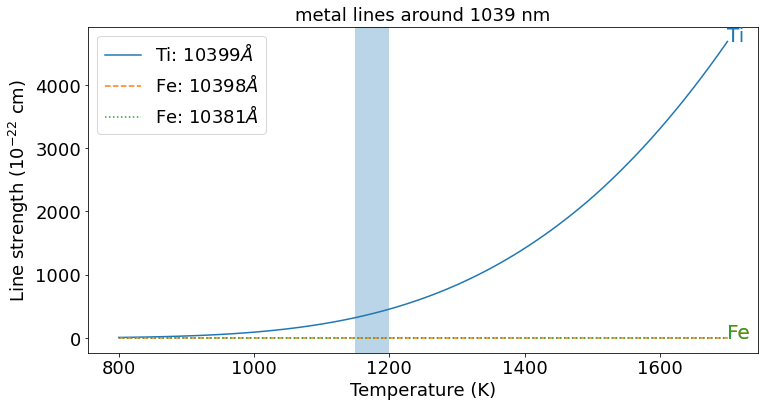

#Note that we ignore the formation of TiO


In [18]:
lsa=["solid","dashed","dotted","dashdot"]
fac=1.e22
fig=plt.figure(figsize=(12,6))
#for i in range(len(mdbM.A)):
#    j=0
for j,i in enumerate([0, 1, 2]):
    w=lab[j]+": "+str(int(1.e8/adbTest.nu_lines[i]))+"$\\AA$"
    plt.plot(Tarr,SijM[:,i]*fac,ls=lsa[j],alpha=1.0,label=w)
    plt.text(Tmax[i],SijM[imax[i],i]*fac-(1-j)*0.3,lab[j],fontsize=20,color="C"+str(j))

#    w=str(int(1.e8/mdbM.nu_lines[i]*(1.0+28.0/300000.)))+"AA"+" i="+str(i)
#    plt.plot(Tarr,SijM[:,i]*fac,color="C"+str(j),ls=lsa[j],alpha=1.0,label=w)
#    plt.text(Tmax[i],SijM[imax[i],i]*fac-(1-j)*0.01*i,str(i),fontsize=20,color="C"+str(j))

    #plt.axvspan(1000.0,1100.0,alpha=0.3)
plt.axvspan(1150.0,1200.0,alpha=0.3)

plt.legend(fontsize=18)

plt.tick_params(labelsize=18)
plt.xlabel("Temperature (K)",fontsize=18)
plt.ylabel("Line strength ($10^{-22}$ cm)",fontsize=18)
plt.title("metal lines around 1039 nm",fontsize=18)
#plt.savefig(path_fig/"lsco.png", bbox_inches="tight", pad_inches=0.0)
#plt.savefig(path_fig/"lsvald3.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

print("#Note that we ignore the formation of TiO") #%\\\\20210817
